# Gut Microbiome of HIV+ Individuals in Rural Appalachia

In [1]:
!qiime info

System versions
Python version: 3.8.12
QIIME 2 release: 2021.11
QIIME 2 version: 2021.11.0
q2cli version: 2021.11.0

Installed plugins
alignment: 2021.11.0
composition: 2021.11.0
cutadapt: 2021.11.0
dada2: 2021.11.0
deblur: 2021.11.0
demux: 2021.11.0
diversity: 2021.11.0
diversity-lib: 2021.11.0
emperor: 2021.11.0
feature-classifier: 2021.11.0
feature-table: 2021.11.0
fragment-insertion: 2021.11.0
gneiss: 2021.11.0
longitudinal: 2021.11.0
metadata: 2021.11.0
phylogeny: 2021.11.0
quality-control: 2021.11.0
quality-filter: 2021.11.0
sample-classifier: 2021.11.0
taxa: 2021.11.0
types: 2021.11.0
vsearch: 2021.11.0

Application config directory
/Users/johnsterrett/mambaforge/envs/qiime2-2021.11/var/q2cli

Getting help
To get help with QIIME 2, visit https://qiime2.org


In [227]:
import os
import sys
import subprocess

from qiime2 import Artifact, Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from skbio import TreeNode

%matplotlib inline

## Initial processing
### Unzip files

`outputs = []
for zipped in os.listdir("hiv-fastqs/"):
    bashCommand = f"unzip hiv-fastqs/{zipped} -d hiv-fastqs/"
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()
    outputs.append((output,error))
`    

`! rm hiv-fastqs/*.zip`

### Import data to qiime2 artifact

`! qiime tools import \
--type 'SampleData[PairedEndSequencesWithQuality]' \
--input-path hiv-fastqs/ \
--input-format CasavaOneEightSingleLanePerSampleDirFmt \
--output-path demux-paired-end.qza`

### Summarize the imported data

`! qiime demux summarize \
--i-data demux-paired-end.qza \
--o-visualization paired-end-summarized.qzv`

In [3]:
viz = Visualization.load("paired-end-summarized.qzv")
viz

<visualization: Visualization uuid: 93906a1a-5d08-48cc-9412-c0c4fb49e9c0>

**Thoughts** - forward

- Overall sequence quality looks awesome. 
- Looks like quality dips over the first 19 reads, which could be primers, so I'll just trim those off.
- Looks like it dips at the very end too. At bp 269, 25 percentile of PHRED is still >30, so I'll truncate there.

Trimming at 19 and 269 still gives us 250 bp - well more than we need, so that's good!

**Thoughts** - reverse
- Overall sequence quality looks good. 
- Not sure if the sequencing folks used reverse primers, so I'll trim at 19 again to be safe. Need to check in on this.
- Looks like it dips as it goes on. At bp 240, 50th percentile of PHRED starting to drop < 30, so I'll truncate there.

Trimming at 19 and 240 still gives us 221 bp - well more than we need, so that's good!

## Denoise using dada2

`! qiime dada2 denoise-paired \
--i-demultiplexed-seqs demux-paired-end.qza \
--p-trim-left-f 19 \
--p-trunc-len-f 269 \
--p-trim-left-r 19 \
--p-trunc-len-r 240 \
--output-dir dada2-out \
--verbose`

`! qiime feature-table summarize \
--i-table dada2-out/table.qza \
--m-sample-metadata-file metadata.txt \
--o-visualization dada2-out/table.qzv`

In [30]:
viz = Visualization.load("dada2-out/table.qzv")
viz

<visualization: Visualization uuid: 46b579bf-281c-4673-bf0e-88349ac5606e>

## SEPP fragment insertion for phylogenetic tree

> ! qiime fragment-insertion sepp \
--i-representative-sequences dada2-out/representative_sequences.qza \
--i-reference-database sepp-refs-silva-128.qza \
--o-tree insertion-tree.qza \
--o-placements insertion-placements.qza

> ! qiime fragment-insertion filter-features \
--i-table dada2-out/table.qza \
--i-tree insertion-tree.qza \
--o-filtered-table filtered-table.qza \
--o-removed-table removed-table.qza

## Assigning taxonomy

> ! qiime feature-classifier classify-sklearn \
--i-reads dada2-out/representative_sequences.qza \
--i-classifier silva-138-99-515-806-nb-classifier.qza \
--output-dir silva-classified

> ! qiime metadata tabulate \
--m-input-file silva-classified/classification.qza \
--o-visualization silva-classified/classification.qzv

>! mv silva-classified/classification.qza taxonomy-silva.qza 

>! mv silva-classified/classification.qzv taxonomy-silva.qzv

In [22]:
viz = Visualization.load('taxonomy-silva.qzv')
viz

<visualization: Visualization uuid: dd486f8b-be31-4bbc-a3f9-83eab4508284>

## Filter mitochondria and chloroplast

>! qiime taxa filter-table \
  --i-table filtered-table.qza \
  --i-taxonomy taxonomy-silva.qza \
  --p-exclude mitochondria,chloroplast \
  --o-filtered-table noMito_noChloro-filtered-table.qza 

In [29]:
dada2_table = Artifact.load('dada2-out/table.qza')
filtered_table = Artifact.load('filtered-table.qza')
no_M_C_table = Artifact.load('noMito_noChloro-filtered-table.qza')

df_tab = dada2_table.view(pd.DataFrame)
df_filt = filtered_table.view(pd.DataFrame)
df_MC = no_M_C_table.view(pd.DataFrame)

tables = ['df_tab', 'df_filt', 'df_MC']


total_frequencies = {x: globals()[x].values.sum() for x in tables}


print('filtered by sepp: {}'.format(total_frequencies['df_tab']-total_frequencies['df_filt']))
print('filtered by Mito/Chloro: {}'.format(total_frequencies['df_filt']-total_frequencies['df_MC']))

filtered by sepp: 0.0
filtered by Mito/Chloro: 256.0


## Taxa barplot

>! qiime taxa barplot \
--i-table noMito_noChloro-filtered-table.qza \
--i-taxonomy taxonomy-silva.qza \
--m-metadata-file metadata.txt \
--o-visualization taxa-barplot.qzv

In [25]:
viz = Visualization.load("taxa-barplot.qzv")
viz

<visualization: Visualization uuid: 62bb5b5c-f10a-4c3d-aea2-c7ed6a71db4e>

## Diversity testing

### Core metrics

>! qiime diversity core-metrics-phylogenetic \
  --i-phylogeny insertion-tree.qza \
  --i-table noMito_noChloro-filtered-table.qza \
  --p-sampling-depth 52495 \
  --m-metadata-file metadata.txt \
  --output-dir core-diversity-results

### Rarefaction

>! qiime diversity alpha-rarefaction \
  --i-table noMito_noChloro-filtered-table.qza \
  --i-phylogeny insertion-tree.qza \
  --p-max-depth 80000 \
  --o-visualization core-diversity-results/alpha-rarefaction.qzv

In [33]:
viz = Visualization.load('core-diversity-results/alpha-rarefaction.qzv')
viz

<visualization: Visualization uuid: 40c7a712-1c89-4a11-81ba-5dd737a02ef9>

### Alpha diversity statistical testing

>! qiime diversity alpha-group-significance \
--i-alpha-diversity core-diversity-results/faith_pd_vector.qza \
--m-metadata-file metadata.txt \
--o-visualization core-diversity-results/faith-pd-group-significance.qzv

>! qiime diversity alpha-correlation \
--i-alpha-diversity core-diversity-results/faith_pd_vector.qza \
--m-metadata-file metadata.txt \
--o-visualization core-diversity-results/faith-pd-correlation.qzv

In [44]:
viz = Visualization.load("core-diversity-results/faith-pd-group-significance.qzv")
viz

<visualization: Visualization uuid: a47458d4-37d1-4097-9e75-a2bf99b65519>

In [43]:
viz = Visualization.load("core-diversity-results/faith-pd-correlation.qzv")
viz

<visualization: Visualization uuid: 182ff713-52c4-4f2c-8556-a4060f5d79be>

### Overall alpha div results 

Faith PD
- HIV not significant (p=0.97)
- Fibroscan 1 (CAP?) was (rho=0.36, p=0.019)
- BMI, Hip to waist, Fibroscan 2 not

<AxesSubplot:>

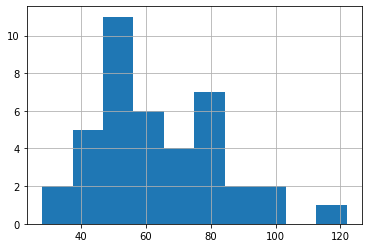

In [165]:
faith.hist()

Faith is looking pretty normally distributed

In [119]:
faith = Artifact.load("core-diversity-results/faith_pd_vector.qza").view(pd.Series)
faith

metadata = pd.read_csv("metadata.txt", sep="\t", index_col="SampleID")
metadata = metadata.loc[faith.index]

In [149]:
faith_glm_df = pd.concat([faith,metadata], axis=1)
faith_glm_df.loc[:,"HIV"] = metadata.loc[:,"HIV"].apply(lambda x: 1 if x=="Yes" else 0)

In [155]:
formula = "faith_pd ~ HIV*Fibroscan"
est = smf.glm(formula=formula, data=faith_glm_df).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               faith_pd   No. Observations:                   40
Model:                            GLM   Df Residuals:                       36
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          295.31
Method:                          IRLS   Log-Likelihood:                -168.41
Date:                Mon, 20 Dec 2021   Deviance:                       10631.
Time:                        14:00:49   Pearson chi2:                 1.06e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2980
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        44.9909     15.876      2.834      0.005      13.875      76.107
HIV             -53.6595     25.981     -2.065      0.039    -104.581      -2.738
Fibroscan         0.0712      0.065      1.098      0.272      -0.056       0.198
HIV:Fibroscan     0.1810      0.096      1.884      0.060      -0.007       0.369
=================================================================================
"""

In [162]:
formula = "faith_pd ~ HIV*Fibroscan_2"
est = smf.glm(formula=formula, data=faith_glm_df).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               faith_pd   No. Observations:                   40
Model:                            GLM   Df Residuals:                       36
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          391.25
Method:                          IRLS   Log-Likelihood:                -174.04
Date:                Mon, 20 Dec 2021   Deviance:                       14085.
Time:                        14:07:24   Pearson chi2:                 1.41e+04
No. Iterations:                     3   Pseudo R-squ. (CS):            0.04658
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          60.1317     17.155      3.505      0.000      26.508      93.756
HIV               -11.0668     20.904     -0.529      0.597     -52.039      29.905
Fibroscan_2         0.3481      3.266      0.107      0.915      -6.053       6.750
HIV:Fibroscan_2     1.8620      3.695      0.504      0.614      -5.381       9.104
===================================================================================
"""

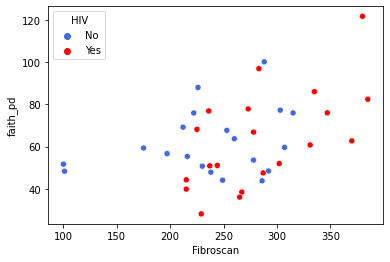

In [160]:
sns.scatterplot(x="Fibroscan", y="faith_pd", hue=metadata["HIV"],
                data=faith_glm_df,
                hue_order=["No", "Yes"],
                palette=["royalblue", "red"])
plt.show()

### Beta diversity statistical testing 

>! qiime diversity beta-group-significance \
--i-distance-matrix core-diversity-results/unweighted_unifrac_distance_matrix.qza \
--m-metadata-file metadata.txt \
--m-metadata-column HIV \
--o-visualization core-diversity-results/unweighted-unifrac-HIV-significance.qzv \
--p-pairwise

In [49]:
viz = Visualization.load("core-diversity-results/unweighted-unifrac-HIV-significance.qzv")
viz

<visualization: Visualization uuid: 1076ef73-3491-498f-bf6d-365ada923a96>

## Differential abundance

>! qiime taxa collapse \
--i-table core-diversity-results/rarefied_table.qza \
--i-taxonomy taxonomy-silva.qza --p-level 2 \
--o-collapsed-table core-diversity-results/phylum-rarefied_table.qza

>! qiime composition add-pseudocount \
--i-table core-diversity-results/phylum-rarefied_table.qza \
--o-composition-table core-diversity-results/phylum-pseudo-rarefied_table.qza

>! qiime composition ancom \
--i-table core-diversity-results/phylum-pseudo-rarefied_table.qza \
--m-metadata-file metadata.txt \
--m-metadata-column HIV \
--o-visualization core-diversity-results/ancom-phylum-HIV.qzv

In [65]:
viz = Visualization.load("core-diversity-results/ancom-phylum-HIV.qzv")
viz

<visualization: Visualization uuid: a078ccb6-9d82-497c-acd1-93499450193b>

In [104]:
data = Artifact.load("core-diversity-results/phylum-rarefied_table.qza").view(pd.DataFrame)

#convert to relative abundances
data_mat = np.matrix(data)
data_mat /= np.sum(data_mat, axis=1)
data = pd.DataFrame(data_mat, index=data.index, columns=data.columns)

Currently missing H19-10

In [105]:
metadata = metadata.loc[data.index]

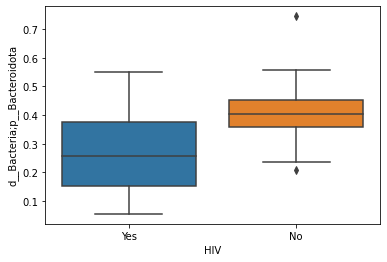

In [109]:
sns.boxplot(x=metadata["HIV"],
            y=data["d__Bacteria;p__Bacteroidota"])
plt.show()

In [166]:
! qiime taxa collapse \
--i-table noMito_noChloro-filtered-table.qza \
--i-taxonomy taxonomy-silva.qza --p-level 6 \
--o-collapsed-table genus-table.qza

! qiime composition add-pseudocount \
--i-table genus-table.qza \
--o-composition-table genus-pseudo-table.qza

! qiime composition ancom \
--i-table genus-pseudo-table.qza \
--m-metadata-file metadata.txt \
--m-metadata-column HIV \
--o-visualization ancom-genus-HIV.qzv

Saved FeatureTable[Frequency] to: genus-table.qza
Saved FeatureTable[Composition] to: genus-pseudo-table.qza
Saved Visualization to: ancom-genus-HIV.qzv


In [168]:
viz = Visualization.load("ancom-genus-HIV.qzv")
viz

<visualization: Visualization uuid: be5932e2-d22c-4154-8e74-c6ed261cc912>

In [169]:
genus = Artifact.load("genus-table.qza").view(pd.DataFrame)

#convert to relative abundances
genus_mat = np.matrix(genus)
genus_mat /= np.sum(genus_mat, axis=1)
genus = pd.DataFrame(genus_mat, index=genus.index, columns=genus.columns)

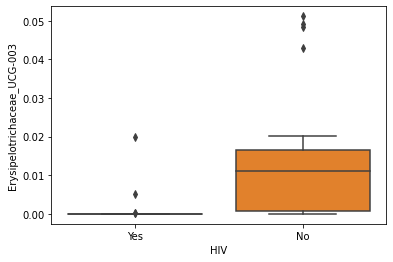

In [171]:
ax = sns.boxplot(x=metadata["HIV"],
            y=genus["d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae;g__Erysipelotrichaceae_UCG-003"])
ax.set_ylabel("Erysipelotrichaceae_UCG-003")
plt.show()

## Songbird

This was done in a QIIME2 2020.6 env because of songbird's dependencies (/opt/anaconda3/envs/qiime2-2020.6-NEW)

### Basic with just Fibroscan

>qiime songbird multinomial \
--i-table noMito_noChloro-filtered-table.qza \
--m-metadata-file metadata.txt \
--p-formula "Fibroscan" \
--p-num-random-test-examples 13 \
--p-summary-interval 1 \
--output-dir songbird_fibroscan

> qiime songbird multinomial \
--i-table noMito_noChloro-filtered-table.qza \
--m-metadata-file metadata.txt \
--p-formula "1" \
--p-num-random-test-examples 13 \
--p-summary-interval 1 \
--output-dir songbird_null

> qiime songbird summarize-single \
--i-regression-stats songbird_fibroscan/regression_stats.qza \
--o-visualization songbird_fibroscan/regression_stats.qzv

>qiime songbird summarize-paired \
--i-regression-stats songbird_fibroscan/regression_stats.qza \
--i-baseline-stats songbird_null/regression_stats.qza \
--o-visualization songbird_fibroscan_comparison.qzv

In [210]:
viz = Visualization.load("songbird_fibroscan_comparison.qzv")
viz

<visualization: Visualization uuid: e9527933-b931-4ceb-86f4-46468dfd6fd0>

Looks like the model isn't a good fit with just fibroscan. Maybe I'll try adding in some other metadata and dropping the differential prior

### HIV + Fibroscan (and hip to waist)

> qiime songbird multinomial \
--i-table noMito_noChloro-filtered-table.qza \
--m-metadata-file metadata.txt \
--p-formula "HIV+Fibroscan+Fibroscan_2" \
--p-num-random-test-examples 13 \
--p-differential-prior 0.5 \
--p-summary-interval 1 \
--output-dir songbird_HIV_fibro1_2

> qiime songbird multinomial \
--i-table noMito_noChloro-filtered-table.qza \
--m-metadata-file metadata.txt \
--p-formula "HIV+Fibroscan+Fibroscan_2+Hip_to_Waist" \
--p-num-random-test-examples 13 \
--p-differential-prior 0.5 \
--p-summary-interval 1 \
--output-dir songbird_hiv_fibro1_2_hipwaist

> qiime songbird summarize-paired \
--i-regression-stats songbird_HIV_fibro1_2/regression_stats.qza \
--i-baseline-stats songbird_null/regression_stats.qza \
--o-visualization songbird_HIV_fibro1_2_comparison.qzv

> qiime songbird summarize-paired \
--i-regression-stats songbird_hiv_fibro1_2_hipwaist/regression_stats.qza \
--i-baseline-stats songbird_null/regression_stats.qza \
--o-visualization songbird_hiv_fibro1_2_hipwaist_comparison.qzv

In [217]:
viz = Visualization.load("songbird_HIV_fibro1_2_comparison.qzv")
viz

<visualization: Visualization uuid: 69008c14-049b-466e-b888-54d4af104b4b>

In [218]:
viz = Visualization.load("songbird_HIV_fibro1_2_hipwaist_comparison.qzv")
viz

<visualization: Visualization uuid: 47f4d5d8-4e1b-47b8-88e8-5481e134b532>

None of these models are getting great performance... 

## Gneiss

### Fibroscan gradient-based clustering

In [219]:
!qiime feature-table filter-features \
--i-table noMito_noChloro-filtered-table.qza \
--p-min-frequency 100 \
--o-filtered-table 100_filtered-table.qza

Saved FeatureTable[Frequency] to: 100_filtered-table.qza


In [220]:
!qiime gneiss gradient-clustering \
    --i-table 100_filtered-table.qza \
    --m-gradient-file metadata.txt \
    --m-gradient-column Fibroscan \
    --o-clustering fibroscan_tree.nwk.qza \
    --p-no-weighted

Saved Hierarchy to: fibroscan_tree.nwk.qza


In [221]:
!qiime composition add-pseudocount \
--i-table 100_filtered-table.qza \
--o-composition-table 100_filtered-pseudo-table.qza

Saved FeatureTable[Composition] to: 100_filtered-pseudo-table.qza


In [222]:
! qiime gneiss ilr-hierarchical \
--i-table 100_filtered-pseudo-table.qza \
--i-tree fibroscan_tree.nwk.qza \
--p-pseudocount 0 \
--o-balances fibroscan_balances.qza

Saved FeatureTable[Balance] to: fibroscan_balances.qza


In [270]:
balances = Artifact.load('fibroscan_balances.qza').view(pd.DataFrame)
tree = Artifact.load("fibroscan_tree.nwk.qza").view(TreeNode)
table = Artifact.load("100_filtered-pseudo-table.qza").view(pd.DataFrame)
taxa = Artifact.load("taxonomy-silva.qza").view(pd.DataFrame)

In [245]:
from gneiss.plot import heatmap
from gneiss.sort import ladderize
from skbio.stats.composition import clr, centralize

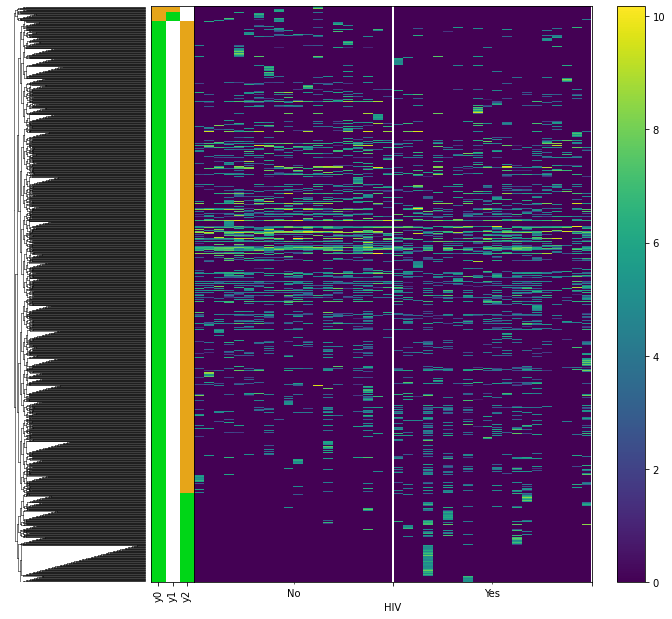

In [243]:
highlights = pd.DataFrame([['#00D617', '#E6A519'],
                           ['#00D617', '#E6A519'],
                           ['#00D617', '#E6A519']],
                          index=['y0', 'y1','y2'], 
                          columns=['numerator', 'denominator'])

_ = heatmap(np.log(table), tree, mdvar=metadata["HIV"], 
            highlights=highlights, figsize=(10, 10))

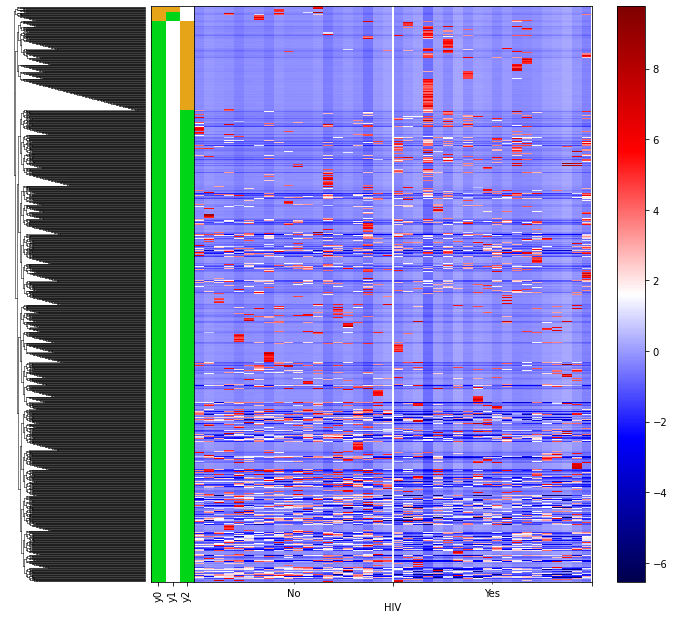

In [253]:
ctable = pd.DataFrame(clr(centralize(table)), index=table.index, columns=table.columns)

sorted_tree = ladderize(tree)

fig = heatmap(ctable, sorted_tree, mdvar=metadata["HIV"], 
            highlights=highlights, figsize=(10, 10), cmap='seismic')

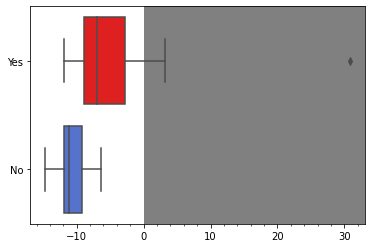

In [264]:
from gneiss.plot import balance_boxplot, balance_barplots
balance_data = pd.merge(balances, metadata, left_index=True, right_index=True)
ax = balance_boxplot('y2', balance_data, y='HIV',
                     num_color='white', denom_color='grey',
                     palette={'Yes': 'red', 'No': 'royalblue'})

In [271]:
taxa = pd.DataFrame(taxa.Taxon.apply(lambda x: x.split(';')).values.tolist(),
                    columns=['kingdom', 'phylum', 'class', 'order', 
                             'family', 'genus', 'species'],
                    index=taxa.index)

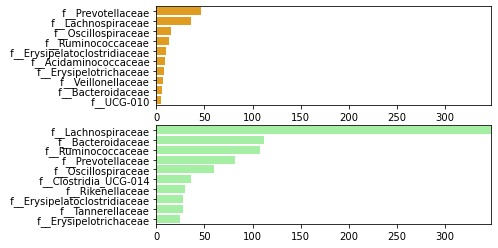

In [274]:
axes = balance_barplots(tree, 'y2', header='family', 
                        feature_metadata=taxa, ndim=10,
                        denom_color='palegreen', 
                        num_color='orange')

### More naive co-occurrence based clustering

In [276]:
!qiime gneiss correlation-clustering \
--i-table 100_filtered-table.qza \
--o-clustering correlation_clustered_tree.qza

Saved Hierarchy to: correlation_clustered_tree.qza


In [277]:
! qiime gneiss ilr-hierarchical \
--i-table 100_filtered-pseudo-table.qza \
--i-tree correlation_clustered_tree.qza \
--p-pseudocount 0 \
--o-balances clustered_balances.qza

Saved FeatureTable[Balance] to: clustered_balances.qza


In [278]:
balances = Artifact.load('clustered_balances.qza').view(pd.DataFrame)
tree = Artifact.load("correlation_clustered_tree.qza").view(TreeNode)

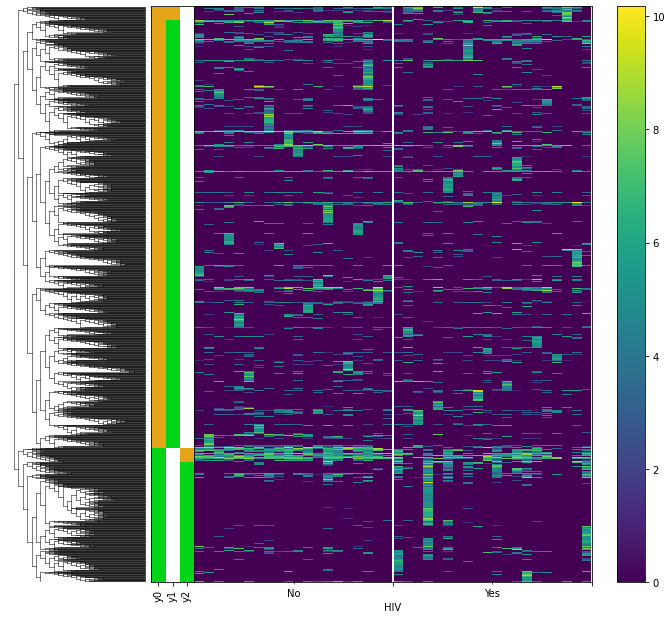

In [279]:
highlights = pd.DataFrame([['#00D617', '#E6A519'],
                           ['#00D617', '#E6A519'],
                           ['#00D617', '#E6A519']],
                          index=['y0', 'y1','y2'], 
                          columns=['numerator', 'denominator'])

_ = heatmap(np.log(table), tree, mdvar=metadata["HIV"], 
            highlights=highlights, figsize=(10, 10))

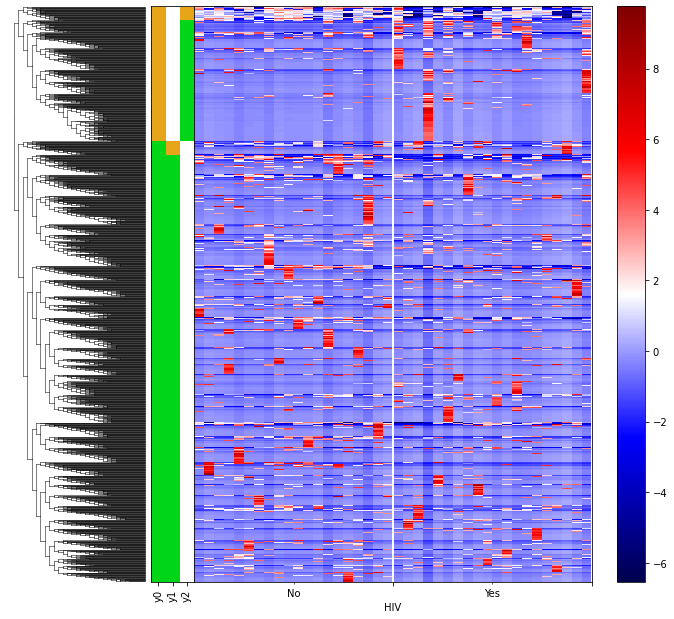

In [280]:
ctable = pd.DataFrame(clr(centralize(table)), index=table.index, columns=table.columns)

sorted_tree = ladderize(tree)

fig = heatmap(ctable, sorted_tree, mdvar=metadata["HIV"], 
            highlights=highlights, figsize=(10, 10), cmap='seismic')

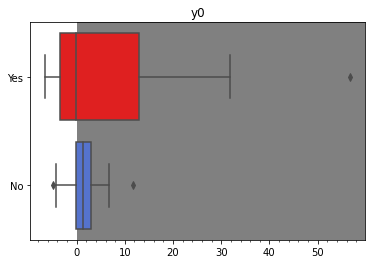

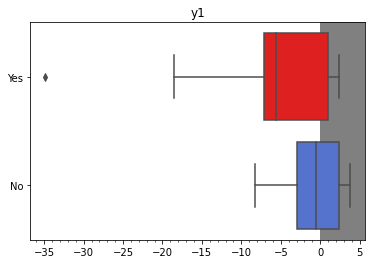

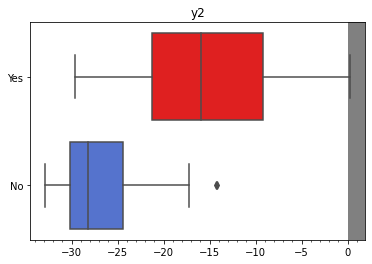

In [282]:
balance_data = pd.merge(balances, metadata, left_index=True, right_index=True)
for cluster in ['y0', 'y1', 'y2']:
    ax = balance_boxplot(cluster, balance_data, y='HIV',
                         num_color='white', denom_color='grey',
                         palette={'Yes': 'red', 'No': 'royalblue'})
    ax.set_title(cluster)
    plt.show()

## Create a L7 tax table for future use

>! qiime taxa collapse \
--i-table noMito_noChloro-filtered-table.qza \
--i-taxonomy taxonomy-silva.qza --p-level 7 \
--o-collapsed-table tax_table.qza

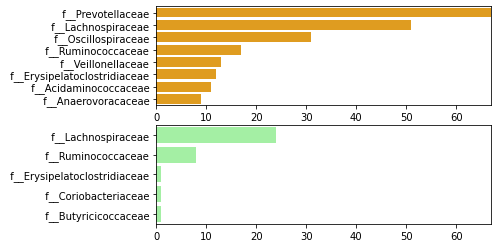

In [284]:
axes = balance_barplots(tree, 'y2', header='family', 
                        feature_metadata=taxa, ndim=8,
                        denom_color='palegreen', 
                        num_color='orange')

## Cluster heatmap

Doesn't really show anything helpful

In [182]:
L7 = Artifact.load("tax_table.qza").view(pd.DataFrame)

#convert to relative abundances
L7_mat = np.matrix(L7)
L7_mat /= np.sum(L7_mat, axis=1)
L7 = pd.DataFrame(L7_mat, index=L7.index, columns=L7.columns)

In [185]:
from skbio.stats.composition import clr

/var/folders/wp/9dsg4hm50lg540x82g1bht1r0000gn/T/ipykernel_24499/386715890.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


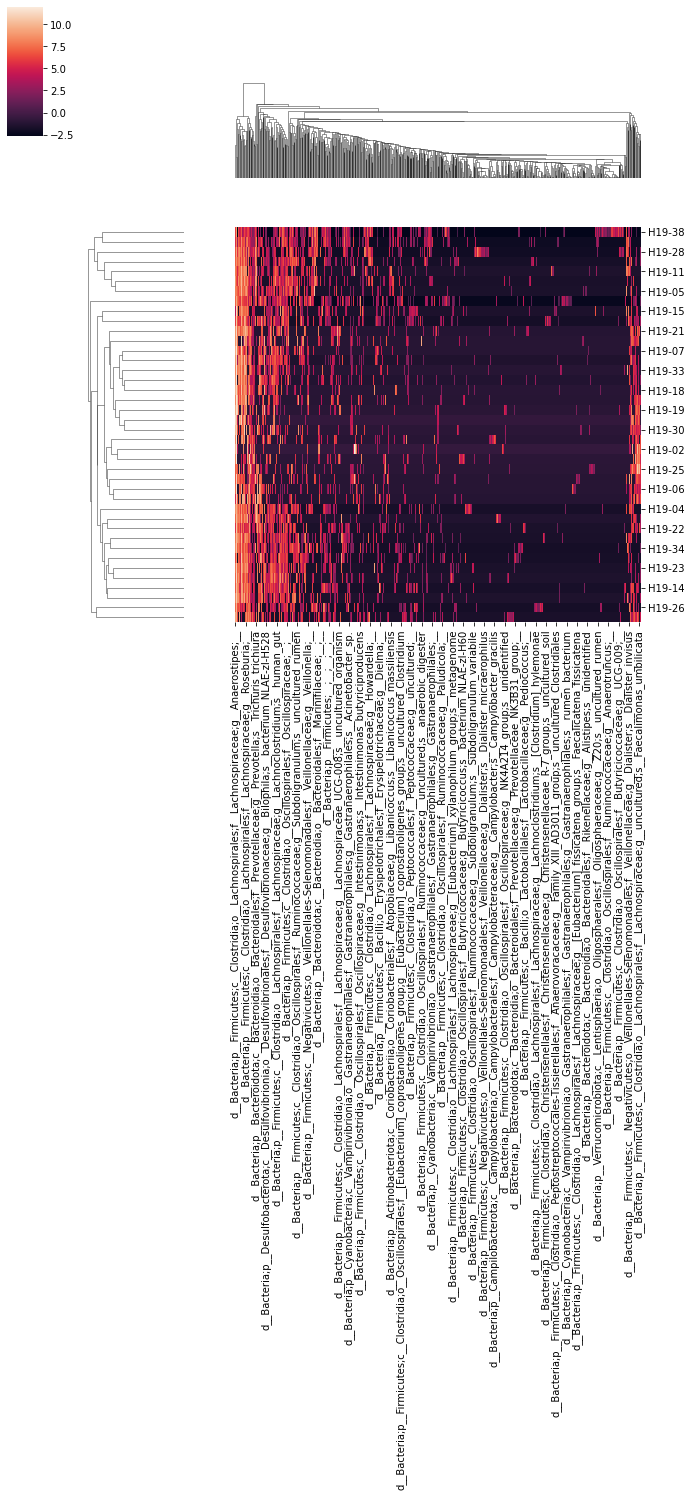

In [206]:
clr_L7 = pd.DataFrame(clr(L7.apply(lambda x: x+0.000001)), 
                      index=L7.index, columns=L7.columns)

sns.clustermap(clr_L7)
plt.tight_layout()